<center>

![image.png](attachment:image.png)
<h2>
Instituto Superior de Engenharia de Lisboa

Licenciatura Engenharia Informática e Multimédia

Ano letivo 2024/2025

Aprendizagem Automática

Trabalho concretizado pelos alunos:

Benjamim Noronha nº50731

Gonçalo Clementino nº50736

Fransisco Sousa nº 50795


Docente: Gonçalo Silva

<h2>

29 de dezembro de 2024
</center>



## Introdução mudar

<h4>
No ambito da unidade curricular Aprendizagem automática, realizou o 1º trabalho prático, em que predente-se cumprir os objetivos propostos.

Estes objetivos são: Escolher 3 classificadores binarios (um deles é o RandomForestClassifier), treinar tais classificadores, escolhendo os melhores hiper-parâmetros, de seguida escolher uma metodologia de treino/teste apropriado para o desempenho ser fidedigno, utilizar metricas apropriadas, para observar, e calibrar o desempenho dos modelos e comparar o desempenho dos classificadores, por fim, observar se usando o pré processamento de dados é benfico para o desempenho de cada classificador.

Neste trabalho será utilizado os classificadores RandomForestClassifier (como pedido no enunciado), Logistic Regression e Support Vetor Machine, para conseguir escolher os melhores híper parametros usou-se o modelo GridSearch e para o pré-processamento de dados usou-se o StandarScaler.
</h4>

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import TfidfVectorizer
import pickle
import re
from nltk.stem import SnowballStemmer, PorterStemmer, LancasterStemmer
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold, cross_val_score, cross_val_predict, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn import svm
import sklearn.preprocessing as pp
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

#### Carrega-se os dados do IMDb

In [39]:
file = open("imdbFull.p", "rb")
dados = pickle.load(file)

In [40]:
print(dados.keys())

dict_keys(['data', 'target', 'DESCR'])


In [41]:
Docs = dados['data']
y = dados['target']
des = dados['DESCR']
des

'This dataset contains movie reviews along with their associated binary sentiment polarity labels. It is intended to serve as a benchmark for sentiment classification. This document outlines how the dataset was gathered, and how to use the files provided.\nFor more details see: http://ai.stanford.edu/~amaas/data/sentiment/'

#### Observa-se que o tipo de dado da critica já esta em string

In [43]:
print(type(Docs[1]))
print(Docs[0])

<class 'str'>
Zero Day leads you to think, even re-think why two boys/young men would do what they did - commit mutual suicide via slaughtering their classmates. It captures what must be beyond a bizarre mode of being for two humans who have decided to withdraw from common civility in order to define their own/mutual world via coupled destruction.<br /><br />It is not a perfect movie but given what money/time the filmmaker and actors had - it is a remarkable product. In terms of explaining the motives and actions of the two young suicide/murderers it is better than 'Elephant' - in terms of being a film that gets under our 'rationalistic' skin it is a far, far better film than almost anything you are likely to see. <br /><br />Flawed but honest with a terrible honesty.


#### 15 a 20 segundos o tfidf

<h4> 
Acontece uma limpeza nas criticas, onde elimina-se as tags br de break, e torna a string em unicode.

Seguidamente, aplica-se um filtro, limpando mais o vocabulario, em que só conta palavras de 4 letras ou mais que apareçam em pelo menos 5 criticas.

In [6]:
# Docs1 = [doc.decode('UTF-8') for doc in Docs_normal] #ja estão em str, n é byte
Docs_normal = [doc.replace('<br />', ' ') for doc in Docs]
Docs_normal = [re.sub(r'[^a-zA-Z\u00C0-\u00FF]+', ' ', doc)
               for doc in Docs_normal]

print(Docs_normal[1])

tfidf_ws = TfidfVectorizer(
    min_df=5, token_pattern=r'\b\w\w\w+\b').fit(Docs_normal)
X_ws = tfidf_ws.transform(Docs_normal)

Words can t describe how bad this movie is I can t explain it by writing only You have too see it for yourself to get at grip of how horrible a movie really can be Not that I recommend you to do that There are so many clichés mistakes and all other negative things you can imagine here that will just make you cry To start with the technical first there are a LOT of mistakes regarding the airplane I won t list them here but just mention the coloring of the plane They didn t even manage to show an airliner in the colors of a fictional airline but instead used a painted in the original Boeing livery Very bad The plot is stupid and has been done many times before only much much better There are so many ridiculous moments here that i lost count of it really early Also I was on the bad guys side all the time in the movie because the good guys were so stupid Executive Decision should without a doubt be you re choice over this one even the Turbulence movies are better In fact every other movie 

In [7]:
X_ws1, X_ws2, ytreino, yteste = train_test_split(
    X_ws, y, test_size=0.2, random_state=0
)
sc = pp.StandardScaler(with_mean=False)
sc1 = sc.fit(X_ws1)

XtreinoN = sc1.transform(X_ws1)
XtesteN = sc1.transform(X_ws2)

In [8]:
dl = LogisticRegression(max_iter=1000, random_state=0).fit(X_ws1, ytreino)
print(dl.score(X_ws1, ytreino))
print(dl.score(X_ws2, yteste))

0.672475
0.4417


In [9]:
dl = LogisticRegression(max_iter=1000, random_state=0).fit(XtreinoN, ytreino)
print(dl.score(XtreinoN, ytreino))
print(dl.score(XtesteN, yteste))

0.999875
0.3635


In [10]:
stemFunc = PorterStemmer()

# Docs1 = [doc.decode('UTF-8') for doc in Docs_ps] #ja estão em str, n é byte
Docs_ps = [''.join(stemFunc.stem(d)) for d in Docs_normal]

print(Docs_ps[1])

tfidf_ps = TfidfVectorizer(
    min_df=5, token_pattern=r'\b\w\w\w+\b').fit(Docs_ps)
X_ps = tfidf_ps.transform(Docs_ps)

words can t describe how bad this movie is i can t explain it by writing only you have too see it for yourself to get at grip of how horrible a movie really can be not that i recommend you to do that there are so many clichés mistakes and all other negative things you can imagine here that will just make you cry to start with the technical first there are a lot of mistakes regarding the airplane i won t list them here but just mention the coloring of the plane they didn t even manage to show an airliner in the colors of a fictional airline but instead used a painted in the original boeing livery very bad the plot is stupid and has been done many times before only much much better there are so many ridiculous moments here that i lost count of it really early also i was on the bad guys side all the time in the movie because the good guys were so stupid executive decision should without a doubt be you re choice over this one even the turbulence movies are better in fact every other movie 

In [11]:
X_ps1, X_ps2, ytreino_ps, yteste_ps = train_test_split(
    X_ps, y, test_size=0.2, random_state=0
)

In [12]:
dl = LogisticRegression(max_iter=1000, random_state=0).fit(X_ps1, ytreino_ps)
print(dl.score(X_ps1, ytreino_ps))
print(dl.score(X_ps2, yteste_ps))

0.675425
0.4401


In [13]:
stemFunc = SnowballStemmer(language='english')

# Docs1 = [doc.decode('UTF-8') for doc in Docs_ss] #ja estão em str, n é byte
Docs_ss = [''.join(stemFunc.stem(d)) for d in Docs_normal]

print(Docs_ss[1])

tfidf_ss = TfidfVectorizer(
    min_df=5, token_pattern=r'\b\w\w\w+\b').fit(Docs_ss)
X_ss = tfidf_ss.transform(Docs_ss)

words can t describe how bad this movie is i can t explain it by writing only you have too see it for yourself to get at grip of how horrible a movie really can be not that i recommend you to do that there are so many clichés mistakes and all other negative things you can imagine here that will just make you cry to start with the technical first there are a lot of mistakes regarding the airplane i won t list them here but just mention the coloring of the plane they didn t even manage to show an airliner in the colors of a fictional airline but instead used a painted in the original boeing livery very bad the plot is stupid and has been done many times before only much much better there are so many ridiculous moments here that i lost count of it really early also i was on the bad guys side all the time in the movie because the good guys were so stupid executive decision should without a doubt be you re choice over this one even the turbulence movies are better in fact every other movie 

In [14]:
X_ss1, X_ss2, ytreino_ss, yteste_ss = train_test_split(
    X_ss, y, test_size=0.2, random_state=0
)

In [15]:
dl = LogisticRegression(max_iter=1000, random_state=0).fit(X_ss1, ytreino_ss)
print(dl.score(X_ss1, ytreino_ss))
print(dl.score(X_ss2, yteste_ss))

0.674325
0.4414


In [16]:
stemFunc = LancasterStemmer()

# Docs_ls1 = [doc.decode('UTF-8') for doc in Docs_ls] #ja estão em str, n é byte
Docs_ls = [''.join(stemFunc.stem(d)) for d in Docs_normal]

print(Docs_ls[1])

tfidf_ls = TfidfVectorizer(
    min_df=5, token_pattern=r'\b\w\w\w+\b').fit(Docs_ls)
X_ls = tfidf_ls.transform(Docs_ls)

words can t describe how bad this movie is i can t explain it by writing only you have too see it for yourself to get at grip of how horrible a movie really can be not that i recommend you to do that there are so many clichés mistakes and all other negative things you can imagine here that will just make you cry to start with the technical first there are a lot of mistakes regarding the airplane i won t list them here but just mention the coloring of the plane they didn t even manage to show an airliner in the colors of a fictional airline but instead used a painted in the original boeing livery very bad the plot is stupid and has been done many times before only much much better there are so many ridiculous moments here that i lost count of it really early also i was on the bad guys side all the time in the movie because the good guys were so stupid executive decision should without a doubt be you re choice over this one even the turbulence movies are better in fact every other movie 

In [17]:
X_ls1, X_ls2, ytreino_ls, yteste_ls = train_test_split(
    X_ls, y, test_size=0.2, random_state=0
)

In [18]:
dl = LogisticRegression(max_iter=1000, random_state=0).fit(X_ls1, ytreino_ls)
print(dl.score(X_ls1, ytreino_ls))
print(dl.score(X_ls2, yteste_ls))

0.67215
0.4416


### 20 min o gridsearch

In [19]:
""" param_grid_logreg = {
    'C': np.arange(0.1, 1.3, 0.1),
    'penalty': np.array(['l1', 'l2']),
    'solver': np.array(['saga', 'lbfgs'])

}
grid_search_logreg = GridSearchCV(
    LogisticRegression(max_iter=1000, random_state=0), param_grid_logreg, n_jobs=-1)
grid_search_logreg.fit(X_ss1, ytreino_ss)
logreg_params = grid_search_logreg.best_params_
print("Best Parameters:", logreg_params)
print("Best Score:", grid_search_logreg.best_score_) """

' param_grid_logreg = {\n    \'C\': np.arange(0.1, 1.3, 0.1),\n    \'penalty\': np.array([\'l1\', \'l2\']),\n    \'solver\': np.array([\'saga\', \'lbfgs\'])\n\n}\ngrid_search_logreg = GridSearchCV(\n    LogisticRegression(max_iter=1000, random_state=0), param_grid_logreg, n_jobs=-1)\ngrid_search_logreg.fit(X_ss1, ytreino_ss)\nlogreg_params = grid_search_logreg.best_params_\nprint("Best Parameters:", logreg_params)\nprint("Best Score:", grid_search_logreg.best_score_) '

In [20]:

logreg_params = {'C': np.float64(
    0.9), 'penalty': np.str_('l2'), 'solver': 'saga'}

In [21]:
dl = LogisticRegression(**logreg_params, max_iter=1000,
                        random_state=0).fit(X_ss1, ytreino_ss)


print(dl.score(X_ss1, ytreino_ss))


print(dl.score(X_ss2, yteste_ss))

0.662175
0.4417


In [22]:
tfidf_ss_bi = TfidfVectorizer(
    min_df=5, token_pattern=r'\b\w\w\w+\b', ngram_range=(1, 2)).fit(Docs_ss)
X_ss_bi = tfidf_ss_bi.transform(Docs_ss)

In [23]:
X_ss1_bi, X_ss2_bi, ytreino_ss_bi, yteste_ss_bi = train_test_split(
    X_ss_bi, y, test_size=0.2, random_state=0
)

In [24]:
dl = LogisticRegression(**logreg_params, max_iter=1000,
                        random_state=0).fit(X_ss1_bi, ytreino_ss_bi)


print(dl.score(X_ss1_bi, ytreino_ss_bi))


print(dl.score(X_ss2_bi, yteste_ss_bi))

0.776675
0.4509


In [25]:

""" dl = svm.SVC(C=1, tol=1e-3, gamma='auto').fit(X_ss1, ytreino)



print(dl.score(X_ss1, ytreino))



print(dl.score(X_ss2, yteste)) """

" dl = svm.SVC(C=1, tol=1e-3, gamma='auto').fit(X_ss1, ytreino)\n\nprint(dl.score(X_ss1, ytreino))\n\nprint(dl.score(X_ss2, yteste)) "

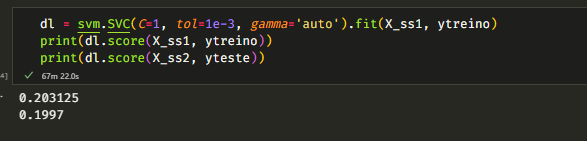

In [26]:
from sklearn.linear_model import Ridge, Lasso

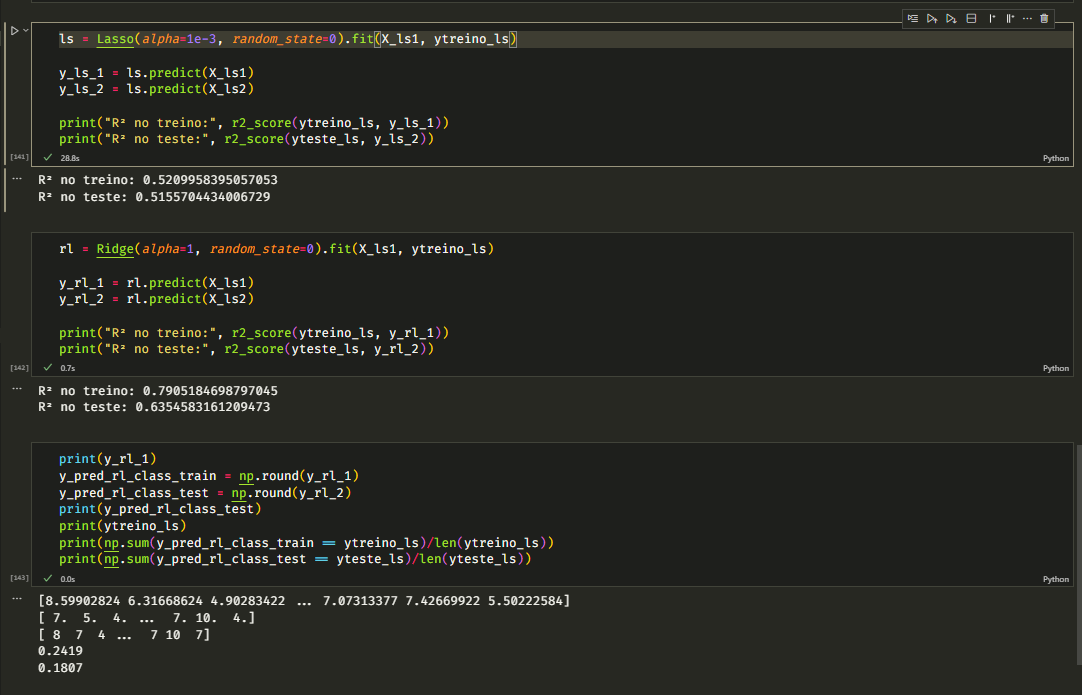

### 1 min

In [27]:
param_grid_lasso = {
    # Altere os valores de alpha conforme necessário
    'alpha': np.array([1e-3, 1e-2, 1e-1, 1, 10])
}

# Configurando o GridSearchCV
grid_search_lasso = GridSearchCV(
    Lasso(random_state=0),  param_grid_lasso, n_jobs=-1
)

# Ajustando o modelo
grid_search_lasso.fit(X_ss1, ytreino_ss)

# Obtendo os melhores parâmetros e score
lasso_params = grid_search_lasso.best_params_
print("Melhor valor de alpha:", lasso_params)
print("Melhor score de validação cruzada (R²):", grid_search_lasso.best_score_)

Melhor valor de alpha: {'alpha': np.float64(0.001)}
Melhor score de validação cruzada (R²): 0.5138510329547669


In [28]:
las = Lasso(**lasso_params, random_state=0).fit(X_ss1, ytreino_ss)

y_las_1 = las.predict(X_ss1)
y_las_2 = las.predict(X_ss2)

print("R² no treino:", r2_score(ytreino_ss, y_las_1))
print("R² no teste:", r2_score(yteste_ss, y_las_2))


print("Erro médio absoluto (MAE) no teste:",
      mean_absolute_error(yteste_ss, y_las_2))
print("Erro médio quadrático (MSE) no teste:",
      mean_squared_error(yteste_ss, y_las_2))

R² no treino: 0.5208076257853331
R² no teste: 0.515397867025337
Erro médio absoluto (MAE) no teste: 2.0290134643565185
Erro médio quadrático (MSE) no teste: 5.859619023047476


In [29]:
print(y_las_2)
y_pred_las_class_test = np.round(y_las_2)
y_pred_las_class_test[y_pred_las_class_test > 10.] = 10.
y_pred_las_class_test[y_pred_las_class_test < 1.] = 1.
y_pred_las_class_test[y_pred_las_class_test == 5.] = 4.
y_pred_las_class_test[y_pred_las_class_test == 6.] = 7.

y_pred_las_class_test
print(y_pred_las_class_test)
print(ytreino_ss)
print(np.sum(y_pred_las_class_test == yteste_ss)/len(yteste_ss))

[7.66065521 5.11056052 5.46761138 ... 6.54724381 8.03655931 5.86311438]
[8. 4. 4. ... 7. 8. 7.]
[ 8  7  4 ...  7 10  7]
0.2155


### quase 1 min

In [30]:
param_grid_ridge = {
    # Altere os valores de alpha conforme necessário
    'alpha': np.array([1e-3, 1e-2, 1e-1, 1, 10])
}

# Configurando o GridSearchCV
grid_search_ridge = GridSearchCV(
    Ridge(random_state=0),  param_grid_ridge, n_jobs=-1
)

# Ajustando o modelo
grid_search_ridge.fit(X_ss1, ytreino_ss)

# Obtendo os melhores parâmetros e score
ridge_params = grid_search_ridge.best_params_
print("Melhor valor de alpha:", ridge_params)
print("Melhor score de validação cruzada (R²):", grid_search_ridge.best_score_)

Melhor valor de alpha: {'alpha': np.float64(1.0)}
Melhor score de validação cruzada (R²): 0.6345658582084799


In [31]:
rl = Ridge(**ridge_params, random_state=0).fit(X_ss1, ytreino_ss)

y_rl_1 = rl.predict(X_ss1)
y_rl_2 = rl.predict(X_ss2)

print("R² no treino:", r2_score(ytreino_ss, y_rl_1))
print("R² no teste:", r2_score(yteste_ss, y_rl_2))

print("Erro médio absoluto (MAE) no teste:",
      mean_absolute_error(yteste_ss, y_rl_2))
print("Erro médio quadrático (MSE) no teste:",
      mean_squared_error(yteste_ss, y_rl_2))

R² no treino: 0.7904298284094093
R² no teste: 0.6354906295696898
Erro médio absoluto (MAE) no teste: 1.6788094416009998
Erro médio quadrático (MSE) no teste: 4.407504415925008


In [32]:
print(y_rl_2)
y_pred_rl_class_test = np.round(y_rl_2)
y_pred_rl_class_test[y_pred_rl_class_test > 10.] = 10.
y_pred_rl_class_test[y_pred_rl_class_test < 1.] = 1.
y_pred_rl_class_test[y_pred_rl_class_test == 5.] = 4.
y_pred_rl_class_test[y_pred_rl_class_test == 6.] = 7.

print(y_pred_rl_class_test)
print(ytreino_ss)
print(np.sum(y_pred_rl_class_test == yteste_ss)/len(yteste_ss))

[ 6.5864819   4.9785682   4.13490727 ...  7.2916463  10.20903429
  4.0752353 ]
[ 7.  4.  4. ...  7. 10.  4.]
[ 8  7  4 ...  7 10  7]
0.2678


In [33]:
from sklearn.linear_model import LinearRegression

In [34]:
""" model = LinearRegression(n_jobs=-1).fit(X_ss1, ytreino)
r2_train = model.score(X_ss1, ytreino)  # R² no conjunto de treino
r2_test = model.score(X_ss2, yteste)    # R² no conjunto de teste
print("R² no conjunto de treino:", r2_train)
print("R² no conjunto de teste:", r2_test)

y_pred_train = model.predict(X_ss1)
y_pred_test = model.predict(X_ss2)

# Avaliação
print("R² no treino:", r2_score(ytreino, y_pred_train))
print("R² no teste:", r2_score(yteste, y_pred_test)) """

' model = LinearRegression(n_jobs=-1).fit(X_ss1, ytreino)\nr2_train = model.score(X_ss1, ytreino)  # R² no conjunto de treino\nr2_test = model.score(X_ss2, yteste)    # R² no conjunto de teste\nprint("R² no conjunto de treino:", r2_train)\nprint("R² no conjunto de teste:", r2_test)\n\ny_pred_train = model.predict(X_ss1)\ny_pred_test = model.predict(X_ss2)\n\n# Avaliação\nprint("R² no treino:", r2_score(ytreino, y_pred_train))\nprint("R² no teste:", r2_score(yteste, y_pred_test)) '

R2 n é usado nos testes, so treino, é uma medida de ajuste do modelo

ver erro quadratico no teste

In [35]:
""" print(y_pred_test)
y_pred_reg_class_test = np.round(y_pred_test)
print(y_pred_reg_class_test) """

' print(y_pred_test)\ny_pred_reg_class_test = np.round(y_pred_test)\nprint(y_pred_reg_class_test) '

fazer os stemms, ver em cada um um classificador simples e dps escolher o que é melhor de score, a partir dai escohe-se o stemm e faz o grid search 

regressor da numeros continuos

arredontar o regressor para a classe mais proxima

questao do stor: se os regressores podem ter classificações como classificadores

k-means, cluster

mattriz de confusao e taxa de desempenho no teste

ver o efeito de ter 2... 10 clusters